In [ ]:
! pip install vallenae

In [ ]:
import matplotlib.pyplot as plt
import vallenae as vae

#HERE = Path(__file__).parent if "__file__" in locals() else Path.cwd()
PRIDB =  "/content/ahmed1.pridb"

#%%
# Open pridb
# ----------
pridb = vae.io.PriDatabase(PRIDB)

In [ ]:
pridb

In [ ]:
with vae.io.PriDatabase(PRIDB) as pridb:
    df_pridb = pridb.read_hits()

Hits: 100%|██████████| 9/9 [00:00<00:00, 11604.28it/s]


In [ ]:
df_pridb

In [ ]:
import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_pridb, *['amplitude'], **{})
chart

Trf: 100%|██████████| 9/9 [00:00<00:00, 18271.41it/s]


           RMS  CrestFactor  SpectralPeakFreq
trai                                         
1     0.000008     4.087043     247524.752475
2     0.000008     4.085646      99009.900990
3     0.000008     4.138582      49504.950495
4     0.000022     7.212967      30185.561769
5     0.000023     5.150749      39592.412989
6     0.000018     2.055362      29411.764706
7     0.000074     9.681774      28087.245740
8     0.000092    11.290593      30419.937032
9     0.000010     3.651877      76277.650648


Hits: 100%|██████████| 9/9 [00:00<00:00, 14479.76it/s]


             time  channel  param_id  amplitude      duration        energy  \
set_id                                                                        
4        7.645751        2         3   0.000033  1.000000e-07      3.526416   
7       10.290745        2         3   0.000034  1.000000e-07      3.286157   
8       13.772396        2         3   0.000033  1.000000e-07      3.532910   
9       13.787570        2         3   0.000161  9.421500e-03    477.492993   
10      13.787684        1         2   0.000117  9.754600e-03    513.336401   
11      13.799290        2         3   0.000037  1.390000e-05      7.710962   
12      15.998458        2         3   0.000716  2.337130e-02  12787.178442   
13      15.998581        1         2   0.001039  2.253090e-02  19107.675903   
14      16.023767        2         3   0.000037  2.421000e-04      9.382178   

             rms     rise_time  counts  trai       RMS  CrestFactor  \
set_id                                                     

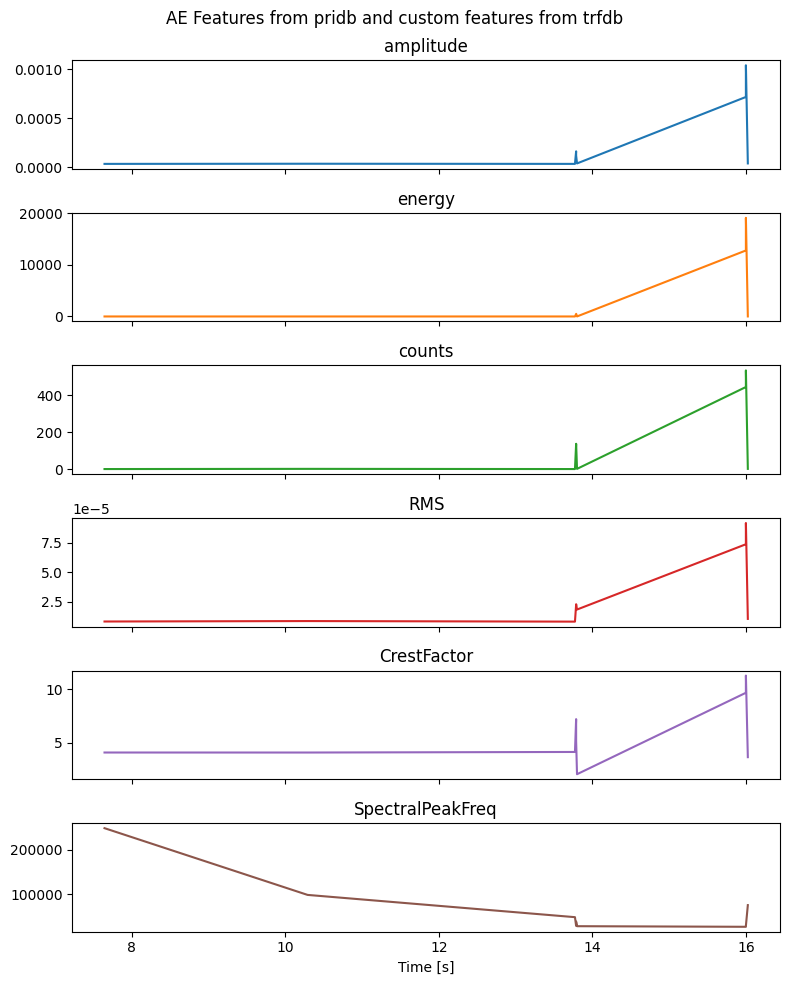

In [ ]:
"""
Custom feature extraction
=========================

Following examples shows how to compute custom features and save them in the transient feature
database (trfdb) to visualize them in VisualAE.

The feature extraction can be live during acquisition. VisualAE will be notified, that a writer to
the trfdb is active and waits for the features to be computed. Therefore, the computed features can
be visualized in real time.
"""

from pathlib import Path
from tempfile import gettempdir

import matplotlib.pyplot as plt
import numpy as np
import vallenae as vae

#HERE = Path(__file__).parent if "__file__" in locals() else Path.cwd()
PRIDB = "/content/ahmed1.pridb"
TRADB = "/content/ahmed1.tradb"
# TRFDB = HERE / "bearing" / "bearing.trfdb"
TRFDB_TMP = Path(gettempdir()) / "bearing_custom.trfdb"  # use a temp file for demo

#%%
# Custom feature extraction algorithms
# ------------------------------------
def rms(data: np.ndarray) -> float:
    """Root mean square (RMS)."""
    return np.sqrt(np.mean(data ** 2))


def crest_factor(data: np.ndarray) -> float:
    """Crest factor (ratio of peak amplitude and RMS)."""
    return np.max(np.abs(data)) / rms(data)


def spectral_peak_frequency(spectrum_: np.ndarray, samplerate: int) -> float:
    """
    Peak frequency in a spectrum.

    Args:
        spectrum: FFT amplitudes
        samplerate: Sample rate of the spectrum in Hz

    Returns:
        Peak frequency in Hz
    """
    def bin_to_hz(samplerate: int, samples: int, index: int):
        return 0.5 * samplerate * index / (samples - 1)

    peak_index = np.argmax(spectrum_)
    return bin_to_hz(samplerate, len(spectrum_), peak_index)

#%%
# Open tradb and trfdb
# --------------------
tradb = vae.io.TraDatabase(TRADB)
trfdb = vae.io.TrfDatabase(TRFDB_TMP, mode="rwc")

#%%
# Helper function to notify VisualAE, that the transient feature database is active/closed
def set_file_status(trfdb_: vae.io.TrfDatabase, status: int):
    """Notify VisualAE that trfdb is active/closed."""
    trfdb_.connection().execute(
        f"UPDATE trf_globalinfo SET Value = {status} WHERE Key == 'FileStatus'"
    )

#%%
# Read tra records, compute features and save to trfdb
# ----------------------------------------------------
# The `vallenae.io.TraDatabase.listen` method will read the tradb row by row and can be used during
# acquisition. Only if the acquisition is closed and no new records are available, the function
# returns.
set_file_status(trfdb, 2)  # 2 = active

for tra in tradb.listen(existing=True, wait=False):
    spectrum = np.fft.rfft(tra.data)
    features = vae.io.FeatureRecord(
        trai=tra.trai,
        features={
            "RMS": rms(tra.data),
            "CrestFactor": crest_factor(tra.data),
            "SpectralPeakFreq": spectral_peak_frequency(spectrum, tra.samplerate),
        }
    )
    trfdb.write(features)

set_file_status(trfdb, 0)  # 0 = closed

#%%
# Write field infos to trfdb
# ~~~~~~~~~~~~~~~~~~~~~~~~~~
# Field infos can be written with `vallenae.io.TrfDatabase.write_fieldinfo`:
trfdb.write_fieldinfo("RMS", {"Unit": "[V]", "LongName": "Root mean square"})
trfdb.write_fieldinfo("CrestFactor", {"Unit": "[]", "LongName": "Crest factor"})
trfdb.write_fieldinfo("SpectralPeakFreq", {"Unit": "[Hz]", "LongName": "Spectral peak frequency"})

#%%
# Read results from trfdb
# -----------------------
df_trfdb = trfdb.read()
print(df_trfdb)

#%%
# Plot AE features and custom features
# ------------------------------------
# Read pridb and join it with trfdb:
with vae.io.PriDatabase(PRIDB) as pridb:
    df_pridb = pridb.read_hits()

df_combined = df_pridb.join(df_trfdb, on="trai", how="left")
print(df_combined)

#%%
# Plot joined features from pridb and trfdb
features = [
    # from pridb
    "amplitude",
    "energy",
    "counts",
    # from trfdb - custom
    "RMS",
    "CrestFactor",
    "SpectralPeakFreq",
]
df_combined.plot(
    x="time",
    y=features,
    xlabel="Time [s]",
    title=features,
    legend=False,
    subplots=True,
    figsize=(8, 10),
)
plt.suptitle("AE Features from pridb and custom features from trfdb")
plt.tight_layout()
plt.show()

#%%
# Display custom features in VisualAE
# -----------------------------------
#
# .. image:: /images/vae_custom_features.png

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import vallenae as vae
import numpy as np

"""
Converted the .DTA file to TRADB via the software
Then trying to read the raw waveforms in TRADB via Python
Successfully can read a waveform from the Tradb file.
https://pyvallenae.readthedocs.io/en/stable/generated/vallenae.io.TraDatabase.html#vallenae.io.TraDatabase
The number of waveforms match, the only issue is the voltage values are different than the ones
extracted from AEWIN
Therefore would need to have the same configuration if want to use vallen instead
"""

def main(tradb_path):
    tradb = Path(tradb_path)
    TRAI = 2# count starts at 1


    with vae.io.TraDatabase(tradb) as tradb:
        print(tradb.fieldinfo())
        full_df = tradb.read()
        voltage_array = np.stack(full_df['data'][1])
        voltage_array_mV = voltage_array * 1e3
        y, t = tradb.read_wave(TRAI)

        y_mv = y * 1e3  # in mV
        t *= 1e6  # for µs

        # Plot waveforms
        plt.figure(figsize=(8, 4), tight_layout=True)
        plt.plot(t, y)
        plt.xlabel("Time [µs]")
        plt.ylabel("Amplitude [V]")
        plt.title(f"Transient Wave Plot; trai = {TRAI}")
        plt.show()

    return full_df, voltage_array, voltage_array_mV


if __name__ == "__main__":
    np.set_printoptions(precision=8)
    tradb_path = r'/content/sarah1.tradb'
    full_df, voltage_array, voltage_array_mV = main(tradb_path)
    print(voltage_array)

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import vallenae as vae
import numpy as np

In [ ]:
tradb = Path('/content/tst2.tradb')

In [ ]:
    with vae.io.TraDatabase(tradb) as tradb:
        print(tradb.fieldinfo())
        full_df = tradb.read()

{'Time': {'Unit': '[s]', 'Parameter': None}, 'Thr': {'Unit': '[µV]', 'Parameter': 'ADC_µV'}, 'SampleRate': {'Unit': '[Hz]', 'Parameter': None}, 'Data': {'Unit': None, 'Parameter': 'TR_mV'}}


Tra: 100%|██████████| 12/12 [00:00<00:00, 183.27it/s]


In [ ]:
full_df

,time,channel,param_id,pretrigger,threshold,samplerate,samples,data,raw
trai,,,,,,,,,
1,32.962676,1,2,100,0.000056,10000000,133842,"[-1.5625001e-06, -1.5625001e-06, -1.5625001e-0...",False
2,32.962738,2,3,100,0.000056,10000000,101822,"[-2.6562502e-05, -2.0312502e-05, -1.09375005e-...",False
3,32.973689,2,3,100,0.000056,10000000,2132,"[-3.125e-05, -2.5000001e-05, -1.71875e-05, -9....",False
4,32.976497,1,2,100,0.000056,10000000,2102,"[1.09375005e-05, 1.09375005e-05, 1.2500001e-05...",False
5,32.977326,1,2,100,0.000056,10000000,117218,"[2.0312502e-05, 2.0312502e-05, 2.1875001e-05, ...",False
6,32.977371,2,3,100,0.000056,10000000,104192,"[1.5625001e-06, 0.0, 0.0, 1.5625001e-06, 1.562...",False
7,32.988630,2,3,100,0.000056,10000000,2104,"[-2.8125001e-05, -2.6562502e-05, -2.5000001e-0...",False
8,32.989446,1,2,100,0.000056,10000000,5766,"[4.0625004e-05, 4.0625004e-05, 3.9062503e-05, ...",False
9,32.990510,1,2,100,0.000056,10000000,2102,"[3.4375e-05, 3.125e-05, 2.6562502e-05, 2.18750...",False


In [ ]:
filtered_df = full_df['data'].where(full_df['channel']==1)

print(filtered_df)

trai
1     [-1.5625001e-06, -1.5625001e-06, -1.5625001e-0...
2                                                   NaN
3                                                   NaN
4     [1.09375005e-05, 1.09375005e-05, 1.2500001e-05...
5     [2.0312502e-05, 2.0312502e-05, 2.1875001e-05, ...
6                                                   NaN
7                                                   NaN
8     [4.0625004e-05, 4.0625004e-05, 3.9062503e-05, ...
9     [3.4375e-05, 3.125e-05, 2.6562502e-05, 2.18750...
10                                                  NaN
11    [-1.5625001e-06, -1.5625001e-06, -1.5625001e-0...
12    [4.3750002e-05, 4.21875e-05, 3.9062503e-05, 3....
Name: data, dtype: object


In [ ]:
new=filtered_df.dropna()
new

trai
1     [-1.5625001e-06, -1.5625001e-06, -1.5625001e-0...
4     [1.09375005e-05, 1.09375005e-05, 1.2500001e-05...
5     [2.0312502e-05, 2.0312502e-05, 2.1875001e-05, ...
8     [4.0625004e-05, 4.0625004e-05, 3.9062503e-05, ...
9     [3.4375e-05, 3.125e-05, 2.6562502e-05, 2.18750...
11    [-1.5625001e-06, -1.5625001e-06, -1.5625001e-0...
12    [4.3750002e-05, 4.21875e-05, 3.9062503e-05, 3....
Name: data, dtype: object

In [ ]:
new.values[0]

array([-1.5625001e-06, -1.5625001e-06, -1.5625001e-06, ...,
        0.0000000e+00, -1.5625001e-06, -3.1250001e-06], dtype=float32)

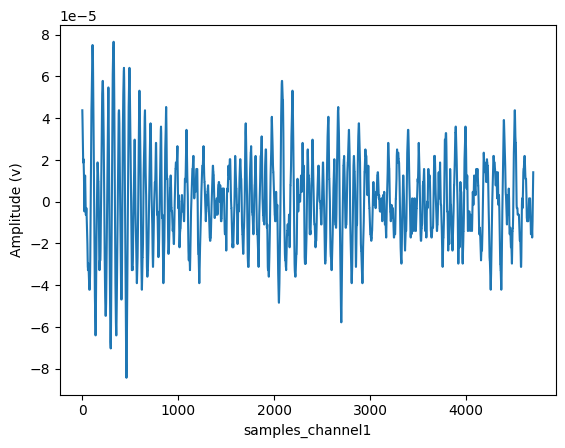

In [ ]:
    plt.figure(1)
    plt.plot(new.values[6])
    plt.xlabel('samples_channel1')
    plt.ylabel('Amplitude (v)')
    plt.show()

In [ ]:
filtered_df2 = full_df['data'].where(full_df['channel']==2)



In [ ]:
new2=filtered_df2.dropna()

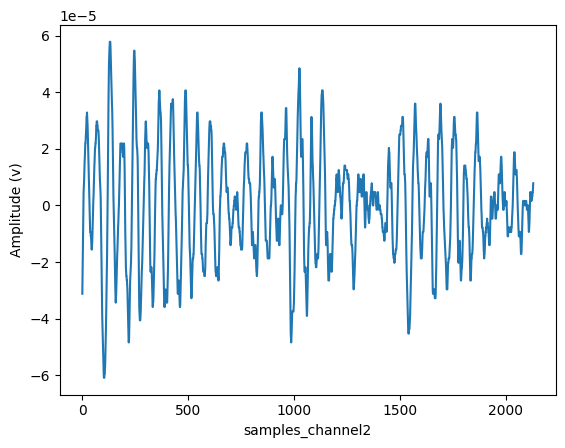

In [ ]:
    plt.figure(5)
    plt.plot(new2.values[1])
    plt.xlabel('samples_channel2')
    plt.ylabel('Amplitude (v)')
    plt.show()